Dados retirados do Kaggle (https://www.kaggle.com/datasets)

* https://www.kaggle.com/datasets/jvanark/nvidia-daily-stock-price-data

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import pandas as pd

# Carregar o dataset
data = pd.read_csv('nvidia_stock_prices.csv')

# Selecionar as colunas de interesse
features = data[['Open', 'High', 'Low', 'Volume']].values  # Usar colunas corretas do dataset de ações
labels = data['Close'].values  # Prever o preço de fechamento

# Dividir os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Normalizar os dados
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Converter para tensores
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)  # Usando .view(-1, 1) para criar a forma correta
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# Definir o modelo de rede neural
class StockPricePredictor(nn.Module):
    def __init__(self):
        super(StockPricePredictor, self).__init__()
        self.fc1 = nn.Linear(X_train.shape[1], 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)  # Saída única para regressão

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Instanciar o modelo
model = StockPricePredictor()

# Definir a função de perda e o otimizador
criterion = nn.MSELoss()  # Mean Squared Error para regressão
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Treinar o modelo
epochs = 50
for epoch in range(epochs):
    model.train()

    # Forward pass
    predictions = model(X_train)
    loss = criterion(predictions, y_train)

    # Backward pass e otimização
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Exibir o progresso a cada 10 épocas
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

# Avaliar o modelo
model.eval()
with torch.no_grad():
    y_pred = model(X_test)
    test_loss = criterion(y_pred, y_test).item()
    print(f'\nLoss no conjunto de teste (MSE): {test_loss:.4f}')

# Converter tensores para arrays do numpy e calcular o erro quadrático médio
y_pred_numpy = y_pred.numpy()
y_test_numpy = y_test.numpy()
mse = mean_squared_error(y_test_numpy, y_pred_numpy)
print(f'Mean Squared Error: {mse:.4f}')


Epoch [10/50], Loss: 116.6462
Epoch [20/50], Loss: 112.0074
Epoch [30/50], Loss: 106.1828
Epoch [40/50], Loss: 98.6070
Epoch [50/50], Loss: 88.1045

Loss no conjunto de teste (MSE): 87.5521
Mean Squared Error: 87.5521


In [ ]:
pip install torch pandas scikit-learn

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import pandas as pd
import numpy as np

# Carregar o dataset
data = pd.read_csv('nvidia_stock_prices.csv')

# Criar a coluna alvo: 1 para subida no preço de fechamento, 0 para queda
data['Price_Change'] = np.where(data['Close'].shift(-1) > data['Close'], 1, 0)  # Se o preço de amanhã for maior, 1 (subida), senão 0 (queda)

# Remover valores ausentes criados pela shift
data = data.dropna()

# Selecionar as colunas de interesse
features = data[['Open', 'High', 'Low', 'Volume']].values
labels = data['Price_Change'].values  # Usar a mudança de preço como classes de classificação

# Dividir os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Normalizar os dados
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Converter para tensores
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

# Definir as dimensões do modelo
input_size = X_train.shape[1]
hidden_size1 = 128
hidden_size2 = 64
output_size = 2  # Duas classes: subida (1) ou queda (0)

# Definir camadas
fc1 = nn.Linear(input_size, hidden_size1)
fc2 = nn.Linear(hidden_size1, hidden_size2)
fc3 = nn.Linear(hidden_size2, output_size)

# Função de ativação
relu = nn.ReLU()

# Função de perda e otimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(list(fc1.parameters()) + list(fc2.parameters()) + list(fc3.parameters()), lr=0.001)

# Função para executar o forward pass
def forward(x):
    x = relu(fc1(x))
    x = relu(fc2(x))
    x = fc3(x)
    return x

# Treinamento
accuracy_list = []
precision_list = []
recall_list = []
f1_list = []
epochs = 100
for epoch in range(epochs):
    optimizer.zero_grad()

    outputs = forward(X_train)
    loss = criterion(outputs, y_train)

    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        # Avaliação em cada 10 épocas
        with torch.no_grad():
            outputs = forward(X_test)
            _, predicted = torch.max(outputs, 1)

            acc = accuracy_score(y_test, predicted)
            precision, recall, f1, _ = precision_recall_fscore_support(y_test, predicted, average='weighted', zero_division=0)

            accuracy_list.append(acc)
            precision_list.append(precision)
            recall_list.append(recall)
            f1_list.append(f1)

            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')
            print(f'Acurácia: {acc:.4f}, Precisão: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}')


Epoch [10/100], Loss: 0.6928
Acurácia: 0.5233, Precisão: 0.4993, Recall: 0.5233, F1: 0.3871
Epoch [20/100], Loss: 0.6919
Acurácia: 0.5253, Precisão: 0.2760, Recall: 0.5253, F1: 0.3618
Epoch [30/100], Loss: 0.6914
Acurácia: 0.5243, Precisão: 0.4950, Recall: 0.5243, F1: 0.3717
Epoch [40/100], Loss: 0.6911
Acurácia: 0.5223, Precisão: 0.5037, Recall: 0.5223, F1: 0.4129
Epoch [50/100], Loss: 0.6908
Acurácia: 0.5273, Precisão: 0.5206, Recall: 0.5273, F1: 0.4269
Epoch [60/100], Loss: 0.6906
Acurácia: 0.5214, Precisão: 0.5047, Recall: 0.5214, F1: 0.4312
Epoch [70/100], Loss: 0.6903
Acurácia: 0.5154, Precisão: 0.4955, Recall: 0.5154, F1: 0.4415
Epoch [80/100], Loss: 0.6901
Acurácia: 0.5114, Precisão: 0.4898, Recall: 0.5114, F1: 0.4435
Epoch [90/100], Loss: 0.6898
Acurácia: 0.5144, Precisão: 0.4955, Recall: 0.5144, F1: 0.4473
Epoch [100/100], Loss: 0.6896
Acurácia: 0.5104, Precisão: 0.4894, Recall: 0.5104, F1: 0.4463


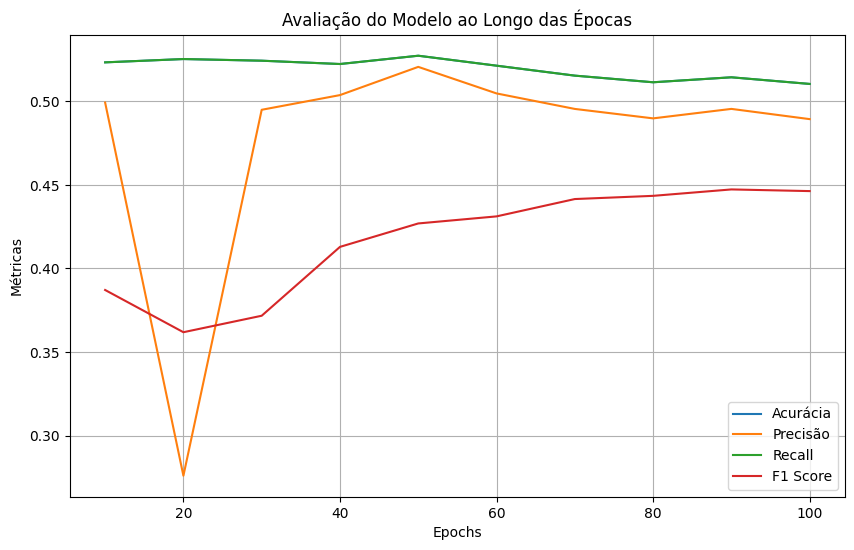

In [ ]:
# Avaliação
epochs_range = range(10, epochs + 1, 10)

plt.figure(figsize=(10, 6))
plt.plot(epochs_range, accuracy_list, label='Acurácia')
plt.plot(epochs_range, precision_list, label='Precisão')
plt.plot(epochs_range, recall_list, label='Recall')
plt.plot(epochs_range, f1_list, label='F1 Score')

plt.xlabel('Epochs')
plt.ylabel('Métricas')
plt.title('Avaliação do Modelo ao Longo das Épocas')
plt.legend()
plt.grid(True)

# Salvar o gráfico (opcional)
plt.savefig('avaliacao_modelo.png')

plt.show()


In [ ]:
# Exibir os resultados finais
print(f'Resultado Final após {epochs} épocas:')
print(f'Acurácia: {accuracy_list[-1]:.4f}')  # Última acurácia
print(f'Precisão: {precision_list[-1]:.4f}')  # Última precisão
print(f'Recall: {recall_list[-1]:.4f}')  # Último recall
print(f'F1 Score: {f1_list[-1]:.4f}')  # Último F1 Score

Resultado Final após 100 épocas:
Acurácia: 0.5104
Precisão: 0.4894
Recall: 0.5104
F1 Score: 0.4463
